In [1]:
!pip install monai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import h5py
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import cv2
from scipy import ndimage
import monai.transforms as mt
from skimage.morphology import remove_small_objects, closing, disk
from skimage.measure import label

In [3]:
directory = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open a random .h5 file to inspect its contents
if h5_files:
    selected_file = random.choice(h5_files)
    file_path = os.path.join(directory, selected_file)
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_337_slice_56.h5', 'volume_293_slice_67.h5', 'volume_149_slice_44.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 5.646616129758377
Array min val: -0.5937104793666795

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


In [4]:
# Data Augmentation Class

class BrainScanAugmentation:
    def __init__(self, p=0.5):
        self.p = p
        
    def random_rotate(self, image, mask):
        if random.random() < self.p:
            angle = random.randint(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        return image, mask
        
    def random_flip(self, image, mask):
        if random.random() < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if random.random() < self.p:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        return image, mask
    
    def adjust_brightness_contrast(self, image):
        if random.random() < self.p:
            brightness_factor = random.uniform(0.8, 1.2)
            contrast_factor = random.uniform(0.8, 1.2)
            
            # Apply to each channel separately
            channels = image.shape[0]
            for i in range(channels):
                image[i] = TF.adjust_brightness(image[i].unsqueeze(0), brightness_factor).squeeze(0)
                image[i] = TF.adjust_contrast(image[i].unsqueeze(0), contrast_factor).squeeze(0)
        
        return image
    
    def add_gaussian_noise(self, image):
        if random.random() < self.p:
            noise = torch.randn_like(image) * random.uniform(0.01, 0.05)
            image = image + noise
            image = torch.clamp(image, 0, 1)
        return image
    
    def add_rician_noise(self, image):
        if random.random() < self.p:
            sigma = random.uniform(0.01, 0.03)
            real_noise = torch.randn_like(image) * sigma
            imag_noise = torch.randn_like(image) * sigma
            noisy_real = image + real_noise
            noisy_imag = imag_noise
            image = torch.sqrt(noisy_real**2 + noisy_imag**2)
            image = torch.clamp(image, 0, 1)
        return image
    
    def simulate_bias_field(self, image):
        if random.random() < self.p:
            channels, height, width = image.shape
            
            x_bias = torch.linspace(-1, 1, width)
            y_bias = torch.linspace(-1, 1, height)
            x_grid, y_grid = torch.meshgrid(x_bias, y_bias, indexing='ij')
            
            a = random.uniform(-0.3, 0.3)
            b = random.uniform(-0.3, 0.3)
            c = random.uniform(-0.3, 0.3)
            
            bias = 1.0 + a * x_grid**2 + b * y_grid**2 + c * x_grid * y_grid
            bias = bias.t().unsqueeze(0).repeat(channels, 1, 1)
            
            biased_image = image * bias
            biased_image = torch.clamp(biased_image, 0, 1)
            return biased_image
        return image
    
    def random_crop_and_resize(self, image, mask):
        if random.random() < self.p:
            _, h, w = image.shape
            
            crop_ratio = random.uniform(0.8, 0.95)
            crop_h = int(h * crop_ratio)
            crop_w = int(w * crop_ratio)
            
            i = random.randint(0, h - crop_h)
            j = random.randint(0, w - crop_w)
            
            image = TF.crop(image, i, j, crop_h, crop_w)
            mask = TF.crop(mask, i, j, crop_h, crop_w)
            
            image = TF.resize(image, [h, w])
            mask = TF.resize(mask, [h, w])
            
        return image, mask
    
    def gamma_correction(self, image):
        if random.random() < self.p:
            gamma = random.uniform(0.7, 1.3)
            image = image ** gamma
            image = torch.clamp(image, 0, 1)
        return image
    
    def local_intensity_variation(self, image):
        if random.random() < self.p:
            channels, height, width = image.shape
            mask_size = random.randint(10, 30)
            
            
            x = random.randint(0, width - mask_size)
            y = random.randint(0, height - mask_size)
            

            y_grid, x_grid = torch.meshgrid(
                torch.arange(height), torch.arange(width), indexing='ij'
            )
            
            dist_from_center = torch.sqrt((x_grid - (x + mask_size//2))**2 + 
                                          (y_grid - (y + mask_size//2))**2)
            
            soft_mask = torch.exp(-(dist_from_center**2) / (2 * (mask_size/3)**2))
            
            intensity_factor = random.uniform(0.8, 1.2)
            
            for c in range(channels):
                variation = (intensity_factor - 1.0) * soft_mask
                image[c] = image[c] * (1 + variation)
                
            image = torch.clamp(image, 0, 1)
        return image
    
    def __call__(self, image, mask):
        image, mask = self.random_rotate(image, mask)
        image, mask = self.random_flip(image, mask)
        image = self.adjust_brightness_contrast(image)
        image = self.add_gaussian_noise(image)
        image = self.add_rician_noise(image)
        image = self.simulate_bias_field(image)
        image = self.gamma_correction(image)
        image = self.local_intensity_variation(image)
        image, mask = self.random_crop_and_resize(image, mask)
        
        return image, mask



In [5]:
# Dataset Class with Preprocessing
class BrainScanDataset(Dataset):
    def __init__(self, file_paths, augment=False, deterministic=False, patch_based=False, patch_size=64):
        self.file_paths = file_paths
        self.augment = augment
        self.augmentation = BrainScanAugmentation(p=0.5)
        self.patch_based = patch_based
        self.patch_size = patch_size
        
        if deterministic: 
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def extract_brain_mask(self, image):
        brain_channel = image[0]
        threshold = np.percentile(brain_channel, 10)  
        brain_mask = brain_channel > threshold
        
        brain_mask = ndimage.binary_closing(brain_mask, structure=np.ones((5, 5)))
        brain_mask = ndimage.binary_fill_holes(brain_mask)
        
        return brain_mask
    
    def standardize_intensity(self, image, brain_mask=None):
        result = np.zeros_like(image)
        
        for i in range(image.shape[0]):
            channel = image[i]
            if brain_mask is not None:
                values = channel[brain_mask]
                if len(values) > 0:
                    mean = np.mean(values)
                    std = np.std(values)
                    if std > 0:
                        normalized = (channel - mean) / (std + 1e-8)
                        result[i] = normalized * brain_mask
                    else:
                        result[i] = channel
            else:
                mean = np.mean(channel)
                std = np.std(channel)
                if std > 0:
                    result[i] = (channel - mean) / (std + 1e-8)
                else:
                    result[i] = channel
        
        result = np.clip(result, -5, 5)
        
        result = (result - result.min()) / (result.max() - result.min() + 1e-8)
        
        return result
    
    def sample_patch(self, image, mask):
        _, h, w = image.shape
        ph, pw = self.patch_size, self.patch_size
        
        
        has_tumor = np.any(mask > 0.5)
        
        if has_tumor and random.random() < 0.8:  
            tumor_locations = np.where(mask[0] > 0.5)  
            if len(tumor_locations[0]) > 0:
                idx = random.randint(0, len(tumor_locations[0]) - 1)
                cy, cx = tumor_locations[0][idx], tumor_locations[1][idx]
                
                cy = max(ph // 2, min(cy, h - ph // 2))
                cx = max(pw // 2, min(cx, w - pw // 2))
                
                y1 = max(0, cy - ph // 2)
                x1 = max(0, cx - pw // 2)
                y2 = min(h, y1 + ph)
                x2 = min(w, x1 + pw)
                
                image_patch = image[:, y1:y2, x1:x2]
                mask_patch = mask[:, y1:y2, x1:x2]
                
                if image_patch.shape[1] != ph or image_patch.shape[2] != pw:
                    pad_y1 = max(0, ph // 2 - cy)
                    pad_x1 = max(0, pw // 2 - cx)
                    pad_y2 = max(0, (cy + ph // 2) - h)
                    pad_x2 = max(0, (cx + pw // 2) - w)
                    
                    image_patch = np.pad(image_patch, ((0, 0), (pad_y1, pad_y2), (pad_x1, pad_x2)), mode='constant')
                    mask_patch = np.pad(mask_patch, ((0, 0), (pad_y1, pad_y2), (pad_x1, pad_x2)), mode='constant')
                
                return image_patch, mask_patch
        
        y1 = random.randint(0, h - ph) if h > ph else 0
        x1 = random.randint(0, w - pw) if w > pw else 0
        y2 = min(h, y1 + ph)
        x2 = min(w, x1 + pw)
        
        image_patch = image[:, y1:y2, x1:x2]
        mask_patch = mask[:, y1:y2, x1:x2]
        
        if image_patch.shape[1] != ph or image_patch.shape[2] != pw:
            pad_y = max(0, ph - image_patch.shape[1])
            pad_x = max(0, pw - image_patch.shape[2])
            
            image_patch = np.pad(image_patch, ((0, 0), (0, pad_y), (0, pad_x)), mode='constant')
            mask_patch = np.pad(mask_patch, ((0, 0), (0, pad_y), (0, pad_x)), mode='constant')
            
        return image_patch, mask_patch
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
            
            brain_mask = self.extract_brain_mask(image)
            
            image = self.standardize_intensity(image, brain_mask)
            
            if self.patch_based:
                image, mask = self.sample_patch(image, mask)
            
            
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)
            
            
            if self.augment:
                image, mask = self.augmentation(image, mask)
                
        return image, mask


h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

split_idx = int(0.8 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]


train_dataset = BrainScanDataset(train_files, augment=True, patch_based=True, patch_size=128)
val_dataset = BrainScanDataset(val_files, deterministic=True, patch_based=False)


train_dataloader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True,
    num_workers=4, 
    pin_memory=True,
    prefetch_factor=2,  
    persistent_workers=True  
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True,
    persistent_workers=True
)


test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=True))


for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break


def visualize_augmentation():
    sample_image, sample_mask = next(iter(DataLoader(val_dataset, batch_size=1, shuffle=True)))
    aug = BrainScanAugmentation(p=1.0) 
    aug_image, aug_mask = aug(sample_image.squeeze(0), sample_mask.squeeze(0))
    plt.figure(figsize=(15, 8))
    for i in range(min(4, sample_image.shape[1])):
        plt.subplot(2, 4, i+1)
        plt.title(f"Original Image Ch{i}")
        plt.imshow(sample_image[0, i].numpy(), cmap='gray')
    
   
    for i in range(min(4, aug_image.shape[0])):
        plt.subplot(2, 4, i+5)
        plt.title(f"Augmented Image Ch{i}")
        plt.imshow(aug_image[i].numpy(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training batch - Images shape: torch.Size([16, 4, 128, 128]) Masks shape: torch.Size([16, 3, 128, 128])
Validation batch - Images shape: torch.Size([16, 4, 240, 240]) Masks shape: torch.Size([16, 3, 240, 240])


In [6]:
# CBAM (Convolutional Block Attention Module) Implementation

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):  
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8, kernel_size=7):  # Changed from 16 to 8
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

# Enhanced Conv Block with Residual Connections and Dropout

def conv_block(in_channels, out_channels, kernel_size=3, activation=nn.ReLU(inplace=True), dropout_p=0.2):
    """Create a conv block with CBAM attention, residual connection, and dropout"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels),
        activation,
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels),
        activation,
        CBAM(out_channels, reduction_ratio=8),  # Reduced ratio for better attention
        nn.Dropout2d(p=dropout_p)  # Added spatial dropout for regularization
    )

# UNet++ with Enhanced Architecture

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, deep_supervision=True, n_filters=32):
        super(UNetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision
        self.activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        # Encoder (Downsampling Path)
        self.enc1 = conv_block(in_channels, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        self.enc2 = conv_block(1 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.enc3 = conv_block(2 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.enc4 = conv_block(4 * n_filters, 8 * n_filters, activation=self.activation, dropout_p=0.2)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Center / Bottleneck
        self.center = conv_block(8 * n_filters, 16 * n_filters, activation=self.activation, dropout_p=0.3)
        
        # Upsampling
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Nested decoder blocks (UNet++ architecture)
        # Level 1 skip connections (up from level 2)
        self.dec1_1 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 2 skip connections
        self.dec2_1 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.dec1_2 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 3 skip connections
        self.dec3_1 = conv_block(4 * n_filters + 8 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec2_2 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec1_3 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 4 skip connections
        self.dec4_1 = conv_block(8 * n_filters + 16 * n_filters, 8 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec3_2 = conv_block(4 * n_filters + 8 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec2_3 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.dec1_4 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Output layers for deep supervision
        if self.deep_supervision:
            self.output1 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output2 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output3 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output4 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
        else:
            self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)

        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        
        # Bottleneck
        bottle = self.center(self.pool(x4))
        
        # Decoder (UNet++ nested architecture)
        # Level 4
        x4_1 = self.dec4_1(torch.cat([x4, self.up(bottle)], dim=1))
        
        # Level 3
        x3_1 = self.dec3_1(torch.cat([x3, self.up(x4)], dim=1))
        x3_2 = self.dec3_2(torch.cat([x3, self.up(x4_1)], dim=1))
        
        # Level 2
        x2_1 = self.dec2_1(torch.cat([x2, self.up(x3)], dim=1))
        x2_2 = self.dec2_2(torch.cat([x2, self.up(x3_1)], dim=1))
        x2_3 = self.dec2_3(torch.cat([x2, self.up(x3_2)], dim=1))
        
        # Level 1
        x1_1 = self.dec1_1(torch.cat([x1, self.up(x2)], dim=1))
        x1_2 = self.dec1_2(torch.cat([x1, self.up(x2_1)], dim=1))
        x1_3 = self.dec1_3(torch.cat([x1, self.up(x2_2)], dim=1))
        x1_4 = self.dec1_4(torch.cat([x1, self.up(x2_3)], dim=1))
        
        # Deep supervision
        if self.deep_supervision:
            output1 = self.output1(x1_1)
            output2 = self.output2(x1_2)
            output3 = self.output3(x1_3)
            output4 = self.output4(x1_4)
            return [output1, output2, output3, output4]
        else:
            output = self.output(x1_4)
            return output

In [7]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The model has {params:,} trainable parameters")
    return params
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return torch.mean(focal_loss)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, focal_weight=0.5, bce_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.bce_weight = bce_weight
        
    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        focal_loss = self.focal_loss(inputs, targets)
        bce_loss = self.bce_loss(inputs, targets)
        
        combined_loss = (self.dice_weight * dice_loss + 
                         self.focal_weight * focal_loss + 
                         self.bce_weight * bce_loss)
        
        return combined_loss


# Enhanced Evaluation Metrics
def calculate_dice_coefficient(pred, target, smooth=1e-5):
    """Calculate Dice coefficient for evaluation"""
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    # Flatten
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

def calculate_iou(pred, target, smooth=1e-5):
    """Calculate IoU/Jaccard index for evaluation"""
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    # Flatten
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def calculate_hausdorff_distance(pred, target, voxel_spacing=(1.0, 1.0)):
    """Calculate the 95th percentile Hausdorff distance"""
    try:
        import cv2
        from scipy.ndimage import distance_transform_edt
        
        pred = torch.sigmoid(pred).cpu().numpy()
        pred = (pred > 0.5).astype(np.uint8)
        target = target.cpu().numpy().astype(np.uint8)
        if np.sum(pred) > 0 and np.sum(target) > 0:
           
            dt_target = distance_transform_edt(1 - target, sampling=voxel_spacing)
            hausdorff_dt = dt_target[pred > 0]
            hausdorff_pred_to_target = np.percentile(hausdorff_dt, 95)
            
           
            dt_pred = distance_transform_edt(1 - pred, sampling=voxel_spacing)
            hausdorff_dt = dt_pred[target > 0]
            hausdorff_target_to_pred = np.percentile(hausdorff_dt, 95)
            
           
            hausdorff = max(hausdorff_pred_to_target, hausdorff_target_to_pred)
            return hausdorff
        else:
            return 100.0
    except:
        return 100.0

In [8]:

# Performance Optimizations

def create_optimized_dataloader(dataset, batch_size, num_workers=4, pin_memory=True, shuffle=True):
    """Create an optimized dataloader with prefetching"""
    return DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,  
        pin_memory=pin_memory,    
        persistent_workers=True if num_workers > 0 else False,  
        drop_last=shuffle        
    )




# Performance Optimizations

def create_optimized_dataloader(dataset, batch_size, num_workers=4, pin_memory=True, shuffle=True):
    """Create an optimized dataloader with prefetching"""
    return DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,  
        pin_memory=pin_memory,    
        persistent_workers=True if num_workers > 0 else False, 
        drop_last=shuffle         
    )

def train_model_optimized(model, train_loader, val_loader, device, num_epochs=20):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-5)
    steps_per_epoch = len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=3e-3,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,  
        div_factor=25,  
        final_div_factor=1000  
    )
    
    # Loss function
    criterion = CombinedLoss(dice_weight=0.5, focal_weight=0.3, bce_weight=0.2)
    
    # Gradient scaler for mixed precision training
    scaler = GradScaler()
    
    # Training metrics
    best_val_dice = 0.0
    train_losses = []
    val_dice_scores = []
    val_iou_scores = []
    
    # Early stopping
    patience = 10
    early_stop_counter = 0
    
    amp_enabled = torch.cuda.is_available()
    
    # Evaluation frequency
    eval_every = 2
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        train_samples = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (images, masks) in enumerate(progress_bar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast(enabled=amp_enabled):
                if hasattr(model, 'deep_supervision') and model.deep_supervision:
                    outputs = model(images)
                    loss = 0
                    for output in outputs:
                        loss += criterion(output, masks) / len(outputs)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            epoch_loss += loss.item() * images.size(0)
            train_samples += images.size(0)
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "LR": f"{scheduler.get_last_lr()[0]:.7f}"
            })
        epoch_loss /= train_samples
        train_losses.append(epoch_loss)
        if (epoch + 1) % eval_every == 0 or epoch == num_epochs - 1:
            val_dice, val_iou = validate_model(model, val_loader, device)
            
            val_dice_scores.append(val_dice)
            val_iou_scores.append(val_iou)
            print(f"Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {epoch_loss:.4f}, "
                f"Val Dice: {val_dice:.4f}, "
                f"Val IoU: {val_iou:.4f}")
        
            if val_dice > best_val_dice:
                best_val_dice = val_dice
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_dice': val_dice,
                    'val_iou': val_iou
                }, 'best_brain_segmentation_model.pth')
                print(f"Saved new best model with Dice score: {val_dice:.4f}")
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping after {patience} evaluations without improvement")
                    break
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

    return {
        'train_losses': train_losses,
        'val_dice_scores': val_dice_scores,
        'val_iou_scores': val_iou_scores,
        'best_val_dice': best_val_dice
    }

def validate_model(model, val_loader, device):
    model.eval()
    val_dice = 0.0
    val_iou = 0.0
    val_samples = 0
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            if hasattr(model, 'deep_supervision') and model.deep_supervision:
                outputs = model(images)[-1]  # Use only the final output for validation
            else:
                outputs = model(images)
            
            # Calculate metrics
            batch_dice = calculate_dice_coefficient(outputs, masks)
            batch_iou = calculate_iou(outputs, masks)
            
            val_dice += batch_dice * images.size(0)
            val_iou += batch_iou * images.size(0)
            val_samples += images.size(0)
    
    val_dice /= val_samples
    val_iou /= val_samples
    
    return val_dice, val_iou



In [9]:
def visualize_individual_and_combined(image, true_mask, pred_mask, num_samples=4):
    """
    Visualize prediction results with individual tumor regions and combined comparison
    - ET: Enhancing Tumor (now shown in red)
    - ED: Edema (remains green)
    - NCR: Necrotic Core (remains blue)
    """
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if isinstance(true_mask, torch.Tensor):
        true_mask = true_mask.cpu().numpy()
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = torch.sigmoid(pred_mask).cpu().numpy() if pred_mask.requires_grad else pred_mask.cpu().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
    
    num_samples = min(num_samples, image.shape[0])
    tumor_classes = ['NCR', 'ED', 'ET']  
    colors = [(0, 1, 0), (0, 0, 1), (1, 0.6, 0)]  
    
    for i in range(num_samples):
        fig = plt.figure(figsize=(20, 8))
        
        base_img = image[i, 0]
        ax_orig = plt.subplot2grid((1, 6), (0, 0))
        ax_orig.imshow(base_img, cmap='gray')
        ax_orig.set_title("Original")
        ax_orig.axis('off')
        
        for c, (class_name, color) in enumerate(zip(tumor_classes, colors)):
            ax = plt.subplot2grid((1, 6), (0, c+1))
            ax.imshow(base_img, cmap='gray')
            
            pred_region = pred_mask[i, c]
            overlay = np.zeros((*base_img.shape, 3), dtype=np.float32)
            for h in range(pred_region.shape[0]):
                for w in range(pred_region.shape[1]):
                    if pred_region[h, w] > 0:
                        overlay[h, w] = color
            
            ax.imshow(overlay, alpha=0.6)
            ax.set_title(f"{class_name}")
            ax.axis('off')
        
        ax_gt = plt.subplot2grid((1, 6), (0, 4))
        ax_gt.imshow(base_img, cmap='gray')
        overlay_gt = np.zeros((*base_img.shape, 3), dtype=np.float32)
        for c, color in enumerate(colors):
            mask = true_mask[i, c]
            for h in range(mask.shape[0]):
                for w in range(mask.shape[1]):
                    if mask[h, w] > 0:
                        overlay_gt[h, w] = color
        
        ax_gt.imshow(overlay_gt, alpha=0.6)
        ax_gt.set_title("Ground Truth")
        ax_gt.axis('off')
        ax_pred = plt.subplot2grid((1, 6), (0, 5))
        ax_pred.imshow(base_img, cmap='gray')
        overlay_pred = np.zeros((*base_img.shape, 3), dtype=np.float32)
        for c, color in enumerate(colors):
            mask = pred_mask[i, c]
            for h in range(mask.shape[0]):
                for w in range(mask.shape[1]):
                    if mask[h, w] > 0:
                        overlay_pred[h, w] = color
        
        ax_pred.imshow(overlay_pred, alpha=0.6)
        ax_pred.set_title("Prediction")
        ax_pred.axis('off')
        plt.suptitle(f"Sample {i+1}", fontsize=16)
        plt.subplots_adjust(wspace=0.1, hspace=0.2, top=0.9)
        plt.show()
def postprocess_prediction_optimized(prediction, min_size=100):
    """Apply post-processing to the prediction mask with optimized operations"""
    prediction = torch.sigmoid(prediction).cpu().numpy()
    binary_mask = (prediction > 0.5).astype(np.uint8)
    processed_mask = np.zeros_like(binary_mask)
    for b in range(binary_mask.shape[0]):
      for c in range(binary_mask.shape[1]):
        mask = binary_mask[b, c]
        labeled_mask = label(mask)
        if labeled_mask.max() > 1:
            clean_mask = remove_small_objects(labeled_mask, min_size=min_size)
        else:
            clean_mask = labeled_mask

        binary_clean_mask = (clean_mask > 0).astype(np.uint8)
        closed_mask = closing(binary_clean_mask, disk(3))
        processed_mask[b, c] = closed_mask
    
    return processed_mask
def predict_with_tta(model, image, device):
    """Test-time augmentation for more robust predictions"""
    model.eval()
    image = image.to(device)
    with torch.no_grad():
        if model.deep_supervision:
            pred_orig = model(image)[-1]
        else:
            pred_orig = model(image)
    
    image_hflip = torch.flip(image, dims=[3])
    with torch.no_grad():
        if model.deep_supervision:
            pred_hflip = model(image_hflip)[-1]
        else:
            pred_hflip = model(image_hflip)
    pred_hflip = torch.flip(pred_hflip, dims=[3])
    
    image_vflip = torch.flip(image, dims=[2])
    with torch.no_grad():
        if model.deep_supervision:
            pred_vflip = model(image_vflip)[-1]
        else:
            pred_vflip = model(image_vflip)
    pred_vflip = torch.flip(pred_vflip, dims=[2])
    pred_combined = (pred_orig + pred_hflip + pred_vflip) / 3.0
    
    return pred_combined
def plot_training_history(history):
    """
    Plot training history metrics including loss and accuracy.
    
    Args:
        history: Dictionary containing training history with keys like 
                'train_loss', 'val_loss', 'train_acc', 'val_acc', etc.
    """
    plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 2)
    
    plt.subplot(gs[0])
    if 'train_loss' in history:
        plt.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(gs[1])
    metrics_plotted = False
    for train_metric, val_metric in [
        ('train_acc', 'val_acc'),
        ('train_accuracy', 'val_accuracy'),
        ('train_dice', 'val_dice'),
        ('train_iou', 'val_iou')
    ]:
        if train_metric in history:
            plt.plot(history[train_metric], label=f'Training {train_metric.split("_")[1].capitalize()}')
            metrics_plotted = True
        if val_metric in history:
            plt.plot(history[val_metric], label=f'Validation {val_metric.split("_")[1].capitalize()}')
            metrics_plotted = True
    
    if not metrics_plotted:
        for key in history:
            if 'loss' not in key.lower():
                plt.plot(history[key], label=key)
                metrics_plotted = True
    
    metric_title = 'Metrics Over Epochs'
    plt.title(metric_title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



Using device: cuda


/tmp/ipykernel_23/3115467827.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


The model has 8,968,074 trainable parameters


Epoch 1/20:   0%|          | 0/2859 [00:00<?, ?it/s]/tmp/ipykernel_23/3115467827.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):
Epoch 1/20: 100%|██████████| 2859/2859 [10:22<00:00,  4.59it/s, Loss=0.1306, LR=0.0003129]


Epoch 1/20 - Train Loss: 0.3424


Validation: 100%|██████████| 715/715 [02:42<00:00,  4.39it/s]


Epoch 2/20 - Train Loss: 0.1839, Val Dice: 0.7078, Val IoU: 0.5557
Saved new best model with Dice score: 0.7078


Epoch 3/20: 100%|██████████| 2859/2859 [10:01<00:00,  4.75it/s, Loss=0.1605, LR=0.0015601]


Epoch 3/20 - Train Loss: 0.1715


Validation: 100%|██████████| 715/715 [02:40<00:00,  4.46it/s]


Epoch 4/20 - Train Loss: 0.1641, Val Dice: 0.7404, Val IoU: 0.5963
Saved new best model with Dice score: 0.7404


Epoch 5/20: 100%|██████████| 2859/2859 [10:07<00:00,  4.71it/s, Loss=0.1345, LR=0.0028072]


Epoch 5/20 - Train Loss: 0.1572


Validation: 100%|██████████| 715/715 [02:40<00:00,  4.46it/s]


Epoch 6/20 - Train Loss: 0.1519, Val Dice: 0.7845, Val IoU: 0.6528
Saved new best model with Dice score: 0.7845


Epoch 7/20: 100%|██████████| 2859/2859 [10:18<00:00,  4.62it/s, Loss=0.1144, LR=0.0029624]


Epoch 7/20 - Train Loss: 0.1466


Validation: 100%|██████████| 715/715 [02:40<00:00,  4.46it/s]


Epoch 8/20 - Train Loss: 0.1401, Val Dice: 0.7688, Val IoU: 0.6311


Epoch 9/20: 100%|██████████| 2859/2859 [10:20<00:00,  4.61it/s, Loss=0.1261, LR=0.0026727]


Epoch 9/20 - Train Loss: 0.1362


Validation: 100%|██████████| 715/715 [02:40<00:00,  4.44it/s]


Epoch 10/20 - Train Loss: 0.1357, Val Dice: 0.7832, Val IoU: 0.6515


Epoch 11/20: 100%|██████████| 2859/2859 [10:50<00:00,  4.40it/s, Loss=0.0935, LR=0.0021508]


Epoch 11/20 - Train Loss: 0.1305


Validation: 100%|██████████| 715/715 [02:40<00:00,  4.46it/s]


Epoch 12/20 - Train Loss: 0.1267, Val Dice: 0.8108, Val IoU: 0.6878
Saved new best model with Dice score: 0.8108


Epoch 13/20: 100%|██████████| 2859/2859 [10:40<00:00,  4.46it/s, Loss=0.1228, LR=0.0014999]


Epoch 13/20 - Train Loss: 0.1248


Validation: 100%|██████████| 715/715 [02:40<00:00,  4.46it/s]


Epoch 14/20 - Train Loss: 0.1225, Val Dice: 0.8194, Val IoU: 0.6993
Saved new best model with Dice score: 0.8194


Epoch 15/20: 100%|██████████| 2859/2859 [10:24<00:00,  4.58it/s, Loss=0.0738, LR=0.0008492]


Epoch 15/20 - Train Loss: 0.1192


Validation: 100%|██████████| 715/715 [02:40<00:00,  4.45it/s]


Epoch 16/20 - Train Loss: 0.1164, Val Dice: 0.8215, Val IoU: 0.7023
Saved new best model with Dice score: 0.8215


Epoch 17/20: 100%|██████████| 2859/2859 [10:38<00:00,  4.47it/s, Loss=0.1527, LR=0.0003273]


Epoch 17/20 - Train Loss: 0.1151


Validation: 100%|██████████| 715/715 [02:42<00:00,  4.41it/s]


Epoch 18/20 - Train Loss: 0.1137, Val Dice: 0.8258, Val IoU: 0.7084
Saved new best model with Dice score: 0.8258


Epoch 19/20: 100%|██████████| 2859/2859 [11:09<00:00,  4.27it/s, Loss=0.0893, LR=0.0000377]


Epoch 19/20 - Train Loss: 0.1142


Validation: 100%|██████████| 715/715 [02:42<00:00,  4.40it/s]


Epoch 20/20 - Train Loss: 0.1125, Val Dice: 0.8263, Val IoU: 0.7092
Saved new best model with Dice score: 0.8263


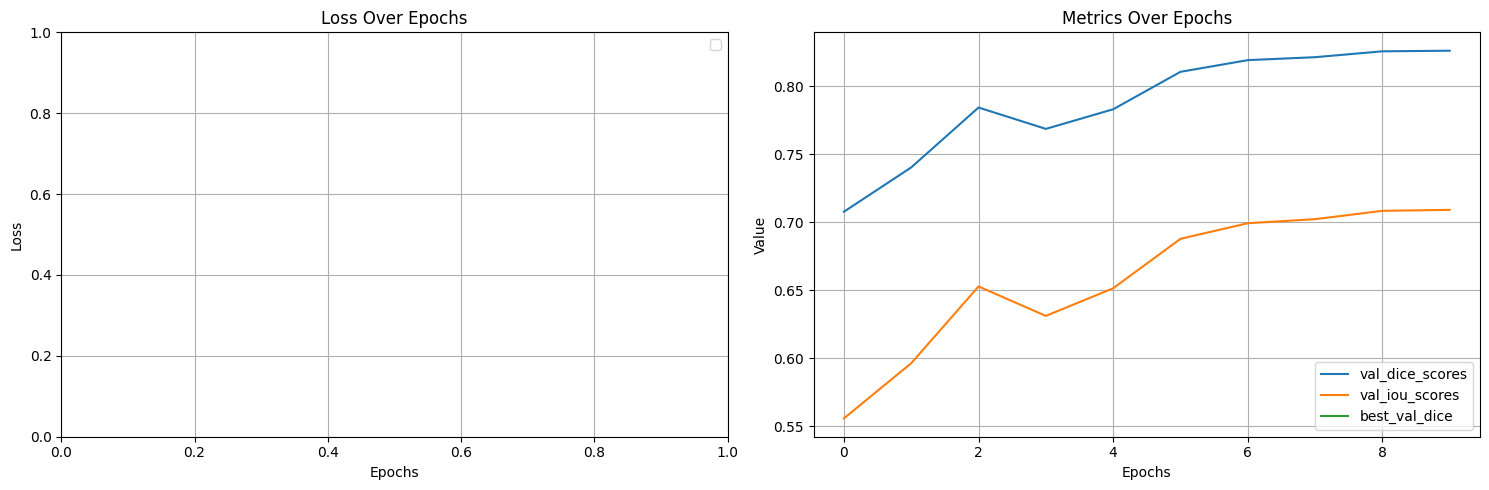

/tmp/ipykernel_23/699406835.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_brain_segmentation_model.pth')


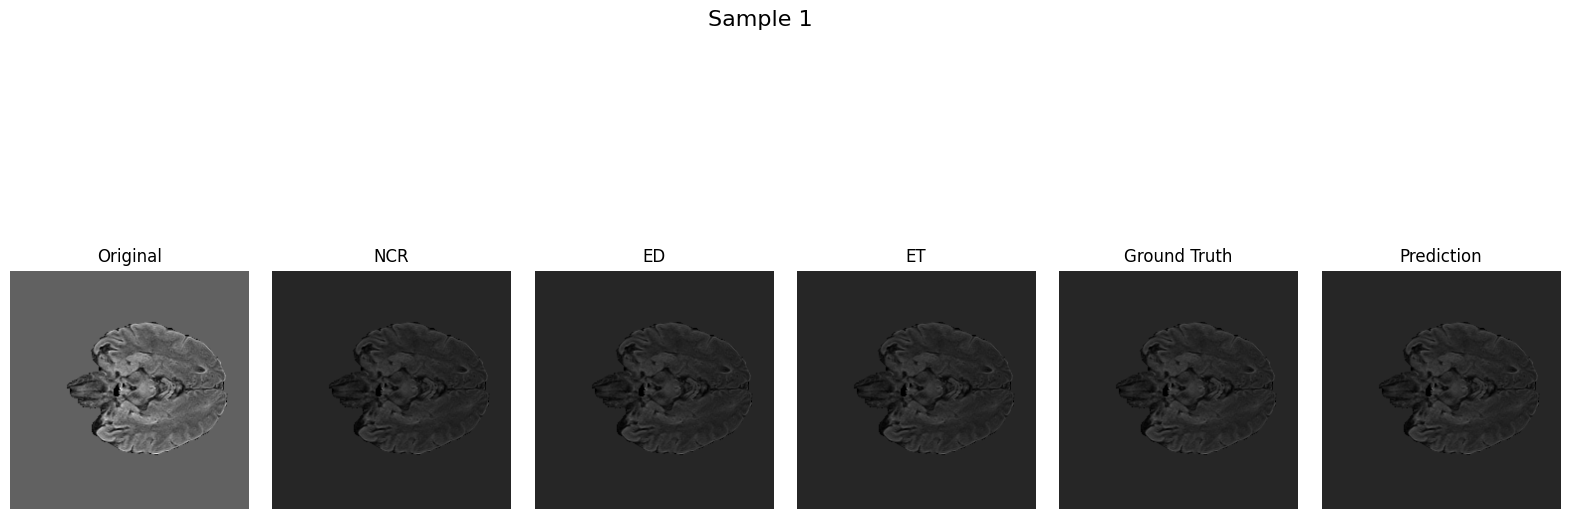

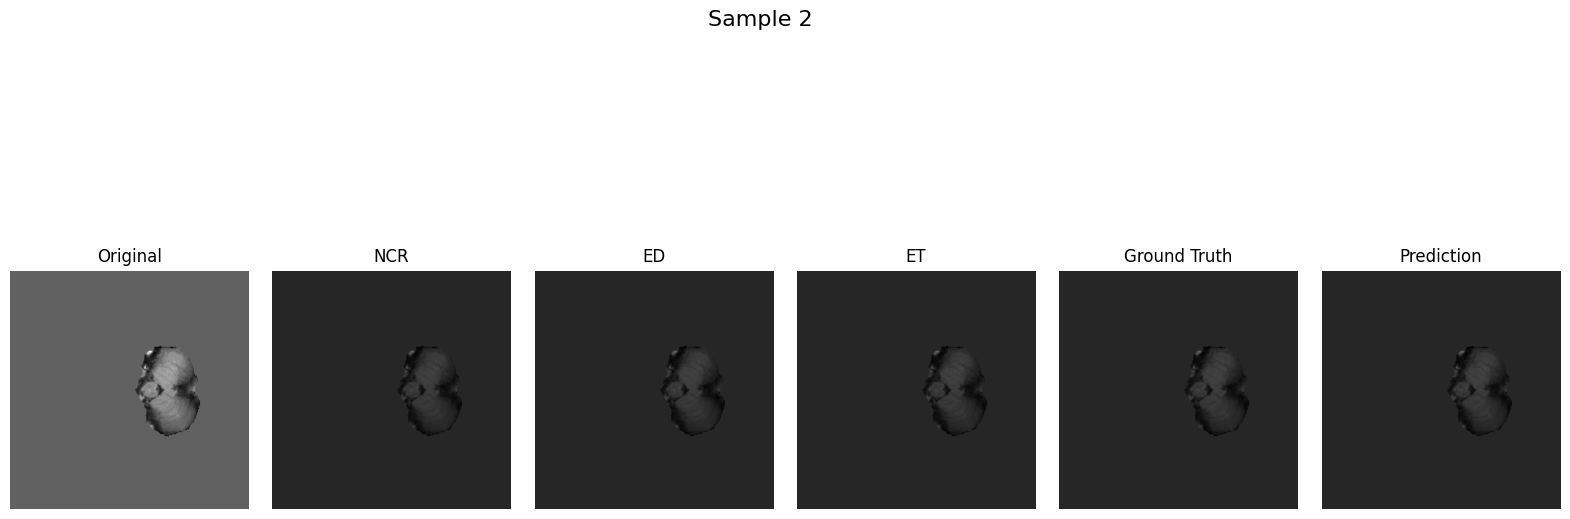

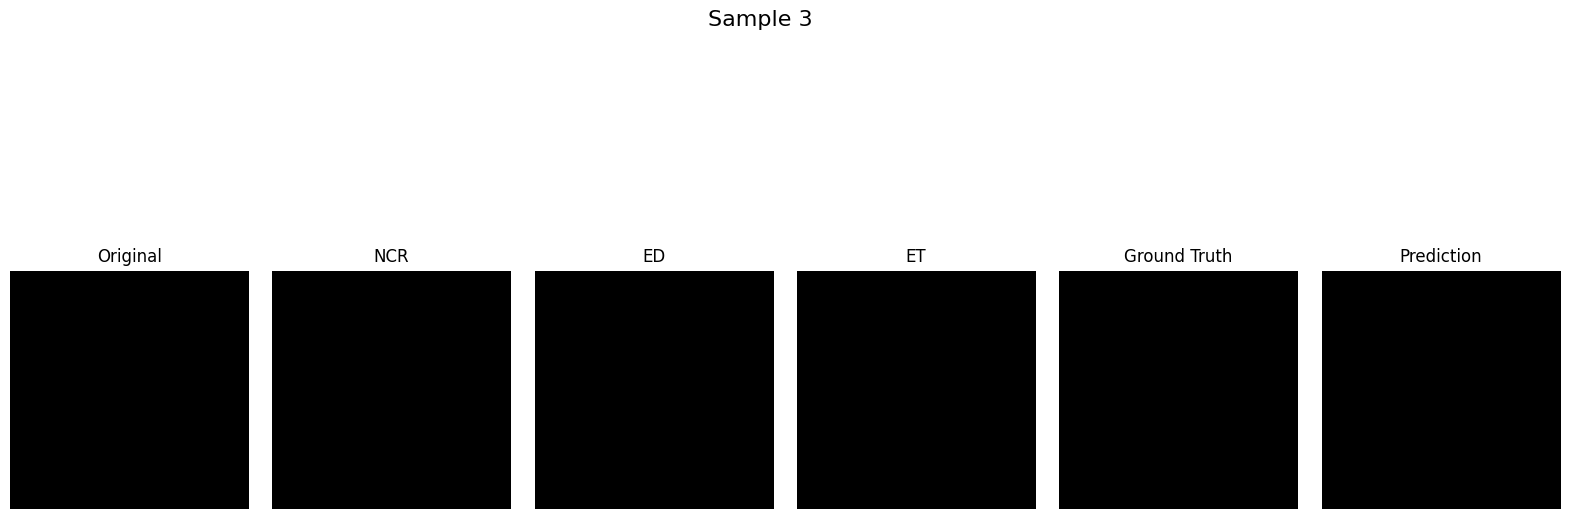

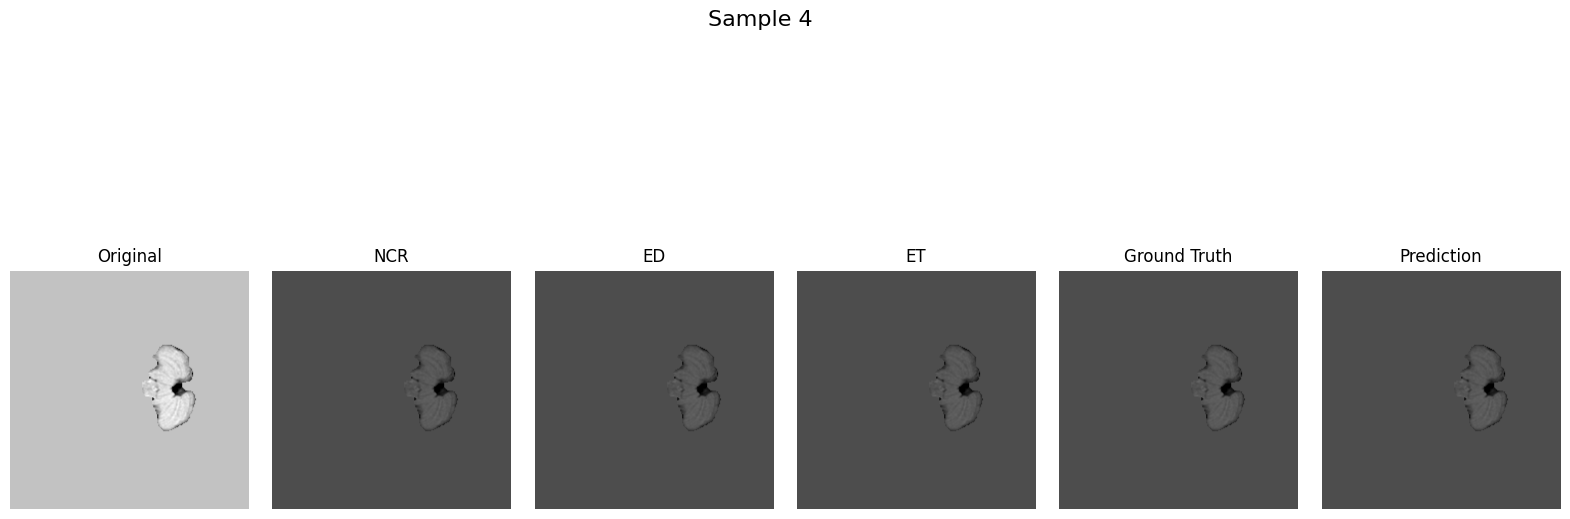

Best validation Dice score: 0.8263


In [10]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    torch.backends.cudnn.benchmark = True
    
    # Initialize model
    model = UNetPlusPlus(in_channels=4, out_channels=3, deep_supervision=True, n_filters=32)
    count_parameters(model)
    
    # Create optimized dataloaders
    train_dataloader_opt = create_optimized_dataloader(train_dataset, batch_size=16, num_workers=4)
    val_dataloader_opt = create_optimized_dataloader(val_dataset, batch_size=16, num_workers=4, shuffle=False)
    
    # Train model with optimized function
    history = train_model_optimized(model, train_dataloader_opt, val_dataloader_opt, device, num_epochs=20)
    
    # Plot training history
    plot_training_history(history)
    
    # Load best model for inference
    best_model = UNetPlusPlus(in_channels=4, out_channels=3, deep_supervision=True, n_filters=32)
    checkpoint = torch.load('best_brain_segmentation_model.pth')
    best_model.load_state_dict(checkpoint['model_state_dict'])
    best_model = best_model.to(device)
    
    # Evaluate on validation set
    val_images, val_masks = next(iter(DataLoader(val_dataset, batch_size=4, shuffle=True)))
    val_images = val_images.to(device)
    
    # Predict with test-time augmentation
    predictions = predict_with_tta(best_model, val_images, device)
    
    # Post-process predictions with optimized function
    processed_preds = torch.tensor(postprocess_prediction_optimized(predictions))
    
    # Visualize results with individual tumor regions
    visualize_individual_and_combined(val_images, val_masks, processed_preds)
    
    print(f"Best validation Dice score: {history['best_val_dice']:.4f}")

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    main()

Using device: cuda


/tmp/ipykernel_23/886169739.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/unetplusplus/pytorch/default/1/best_brain_segmentatio

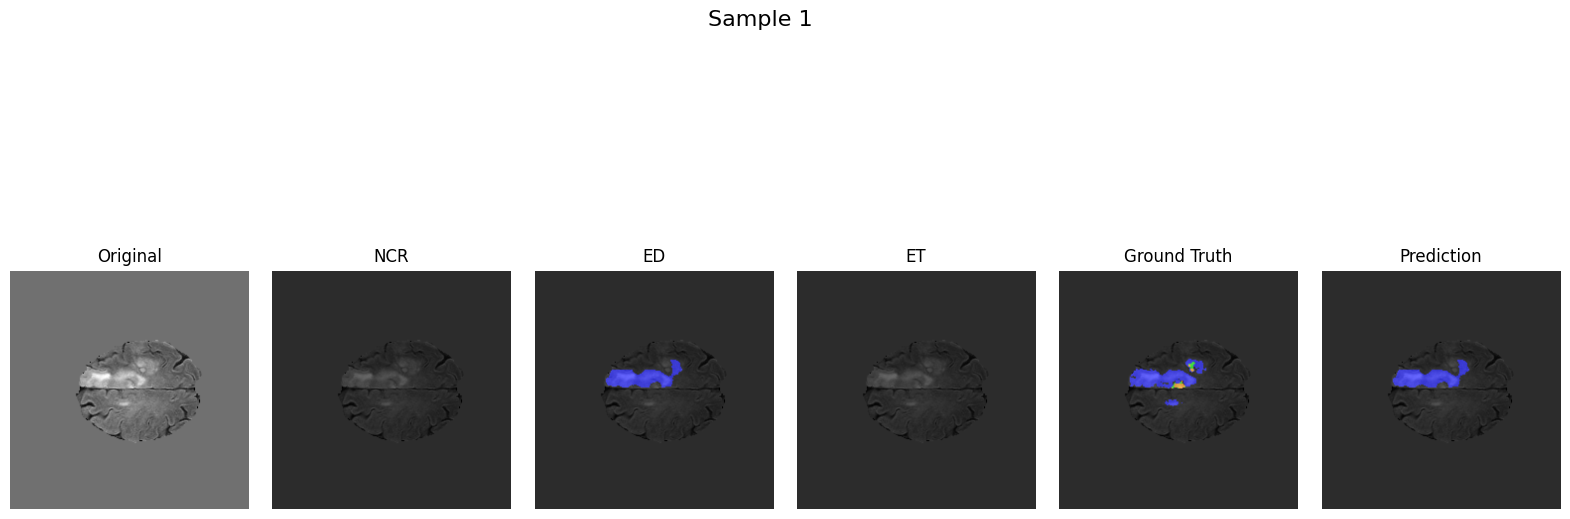

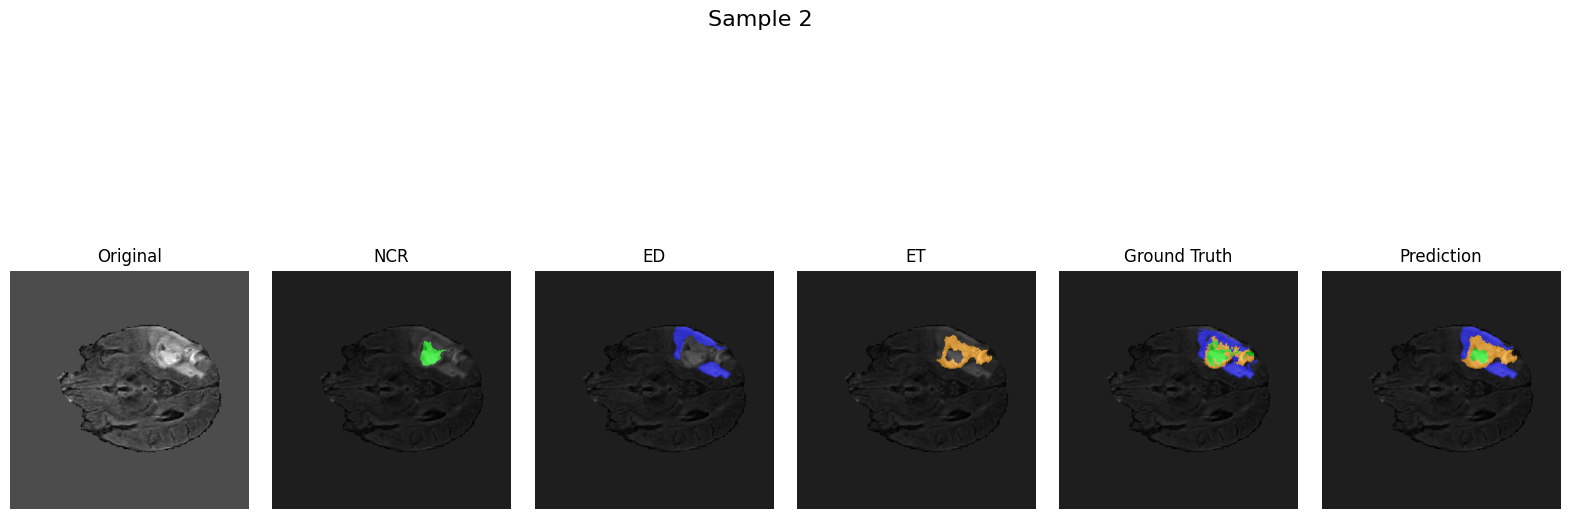

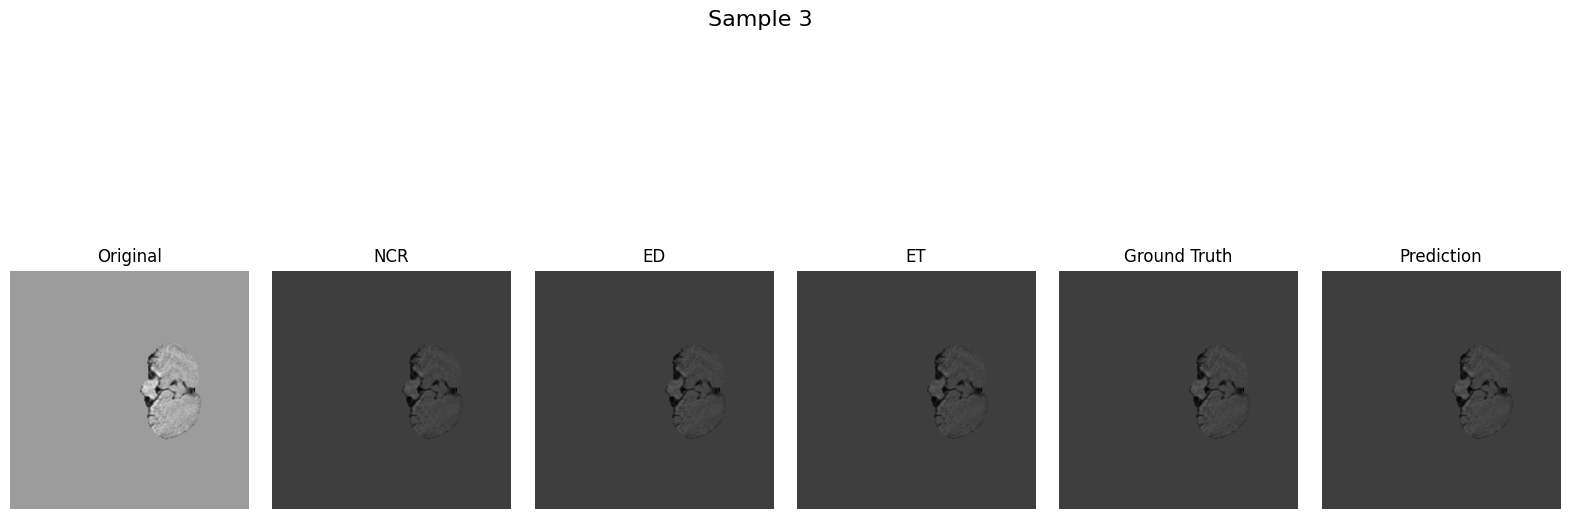

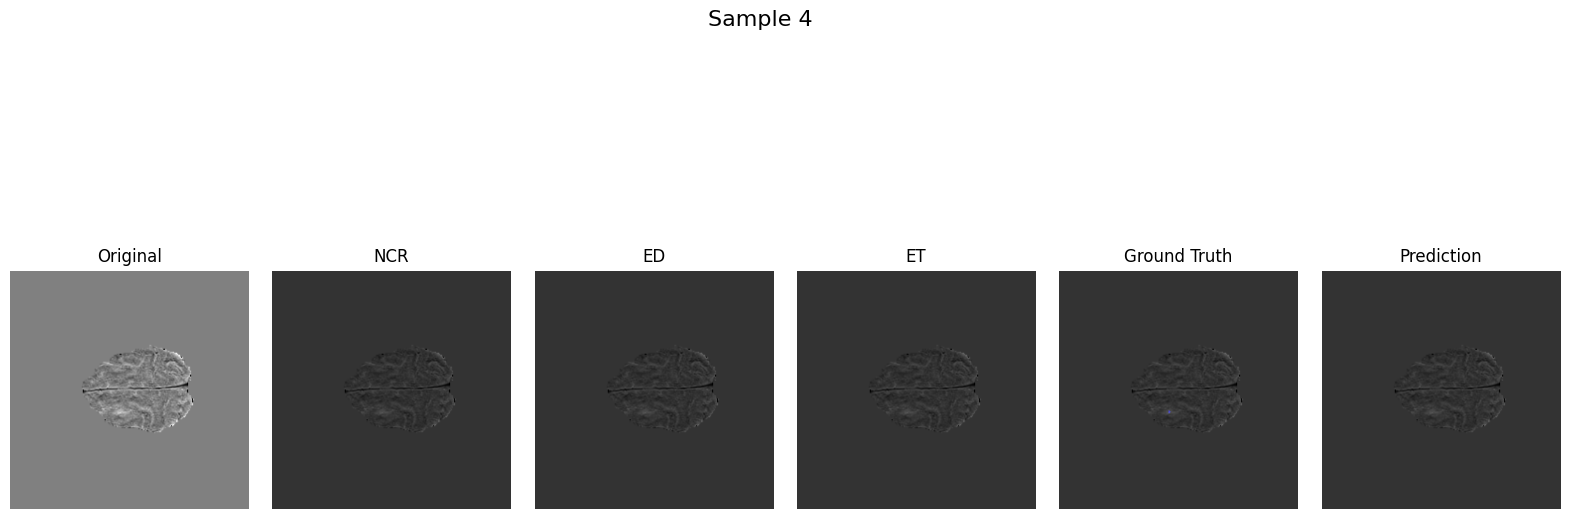

In [11]:
#Visualizing from a checkpoint
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Performance optimization
    torch.backends.cudnn.benchmark = True

    # Initialize model architecture
    best_model = UNetPlusPlus(in_channels=4, out_channels=3, deep_supervision=True, n_filters=32)
    
    # Load the previously trained model from custom path
    checkpoint = torch.load('/kaggle/input/unetplusplus/pytorch/default/1/best_brain_segmentation_model.pth', map_location=device)
    best_model.load_state_dict(checkpoint['model_state_dict'])  # or directly checkpoint if it's just state_dict
    best_model = best_model.to(device)
    best_model.eval()

    # Evaluate on validation set
    val_images, val_masks = next(iter(DataLoader(val_dataset, batch_size=4, shuffle=True)))
    val_images = val_images.to(device)
    
    # Predict with test-time augmentation
    predictions = predict_with_tta(best_model, val_images, device)
    
    # Post-process predictions
    processed_preds = torch.tensor(postprocess_prediction_optimized(predictions))

    # Visualize results
    visualize_individual_and_combined(val_images, val_masks, processed_preds)

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    main()


/tmp/ipykernel_23/2404809327.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)
Ensemble Validation: 100%|██████████| 71

Ensemble Validation Dice: 0.8237, IoU: 0.7051


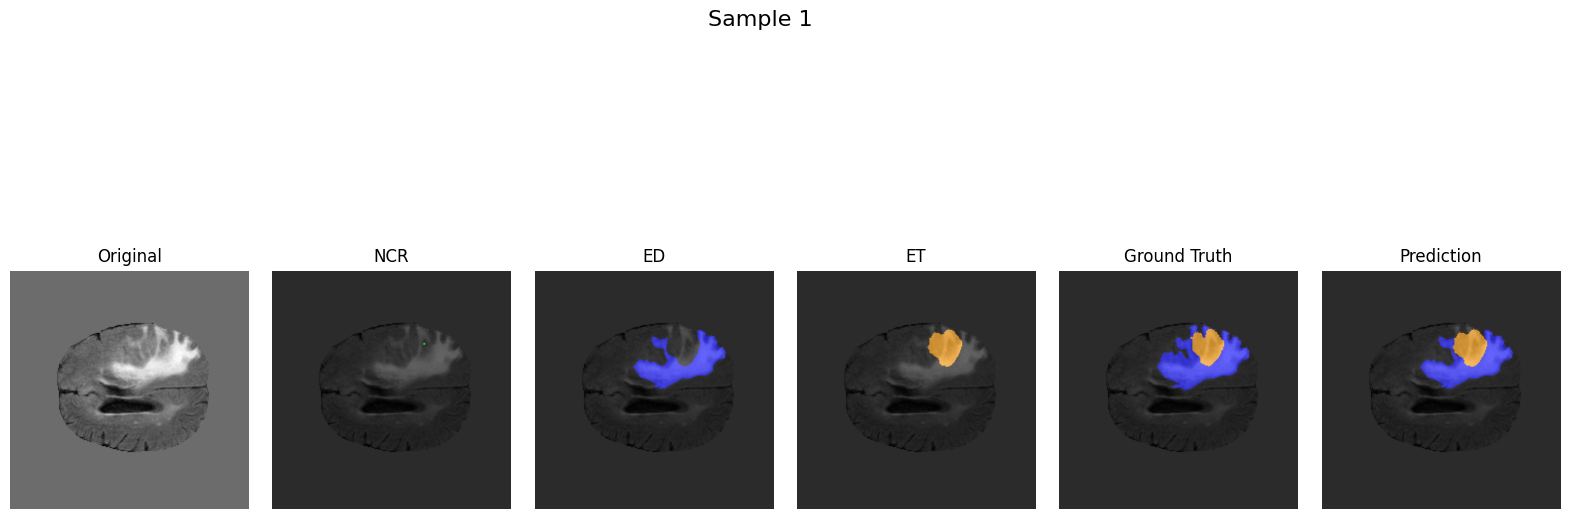

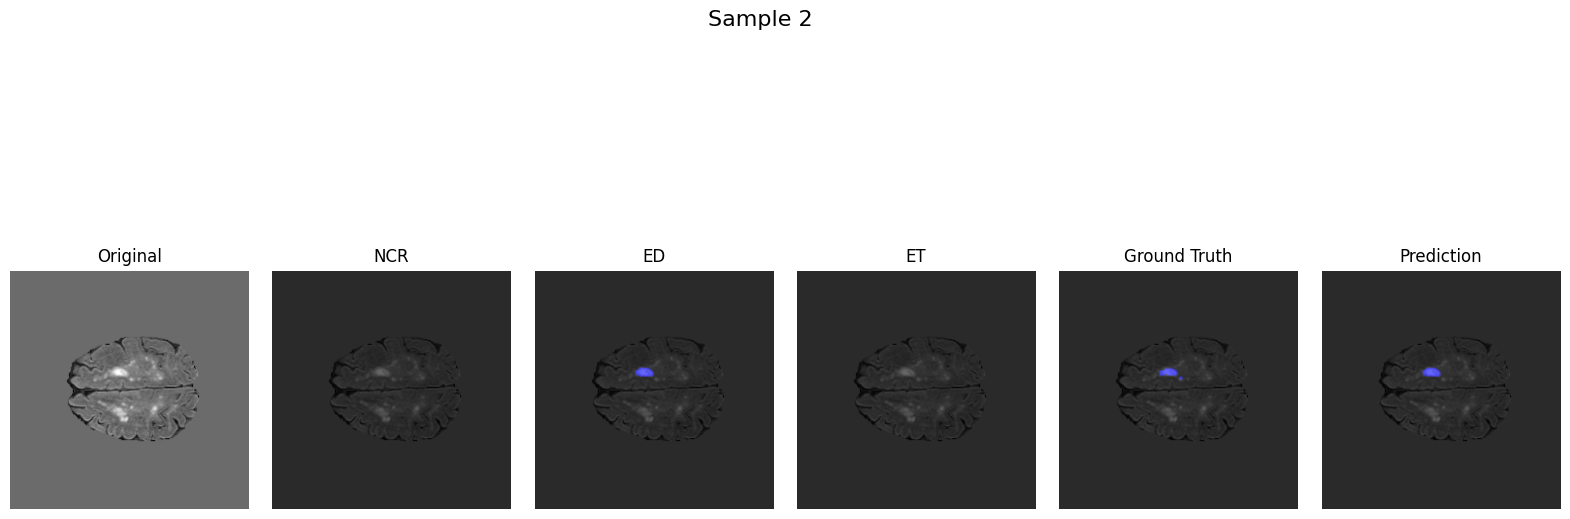

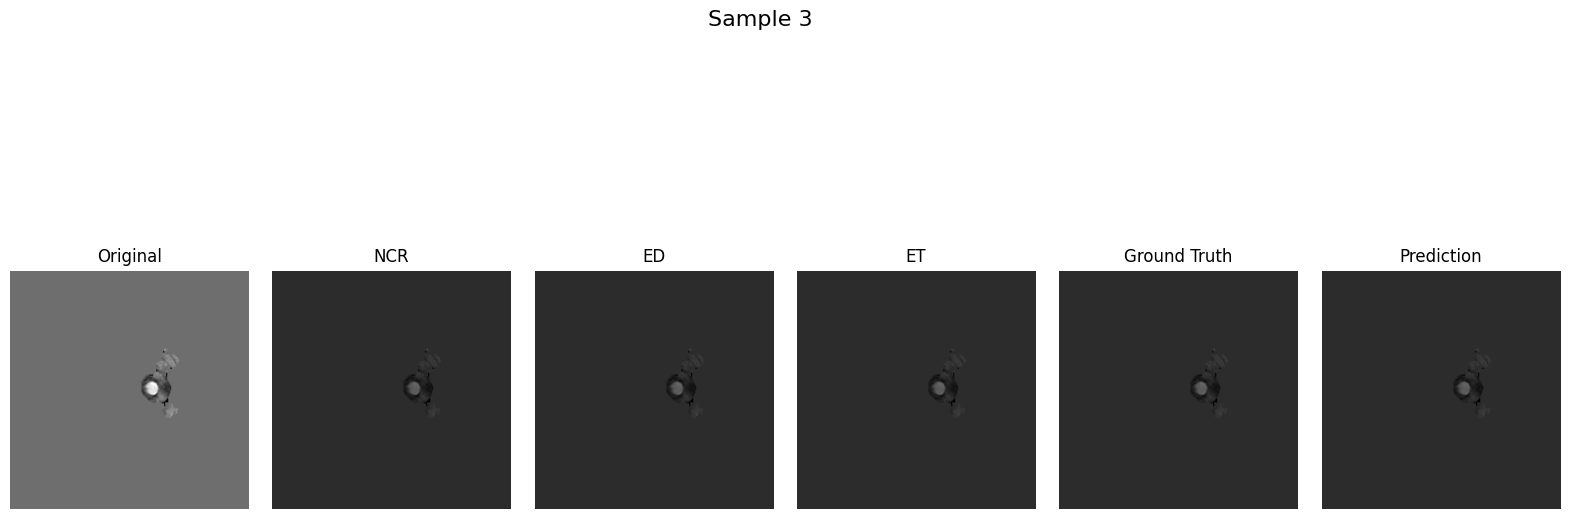

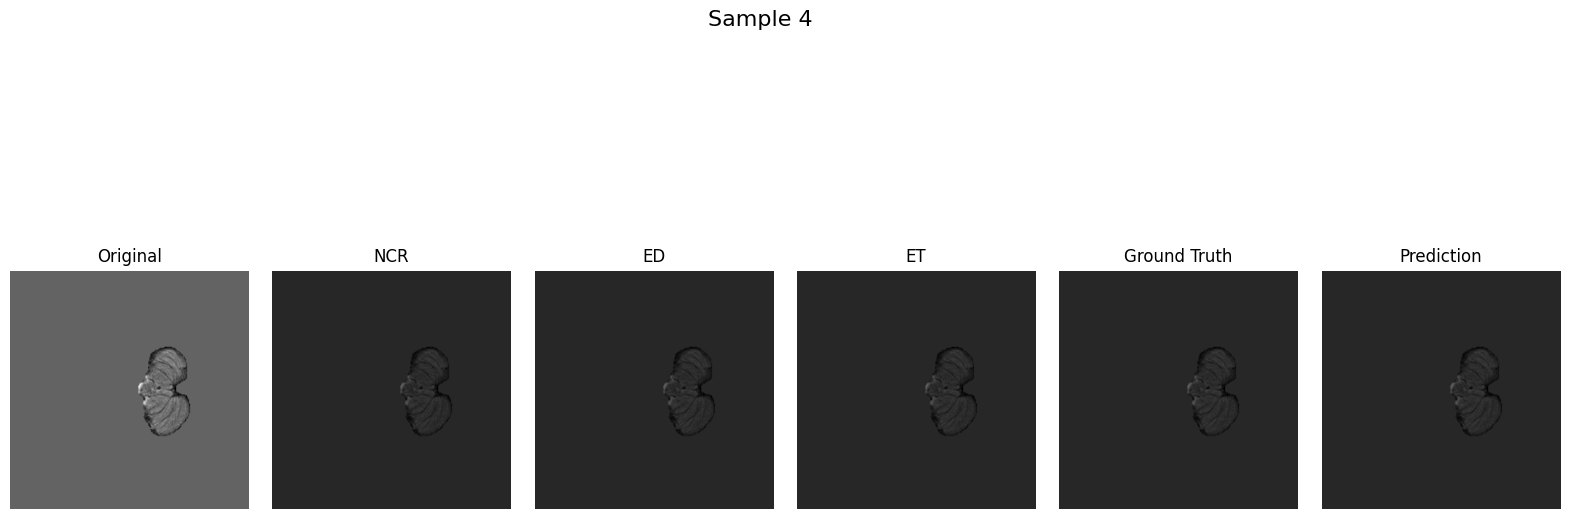

In [12]:
# Ensemble Model with Multiple Checkpoints
class BrainSegmentationEnsemble(nn.Module):
    def __init__(self, checkpoint_paths, device, deep_supervision=True):
        super().__init__()
        self.models = nn.ModuleList()
        self.deep_supervision = deep_supervision
        self.device = device
        
        # Load multiple pre-trained models
        for path in checkpoint_paths:
            model = UNetPlusPlus(in_channels=4, out_channels=3, 
                                deep_supervision=deep_supervision, n_filters=32)
            checkpoint = torch.load(path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            model.eval()
            self.models.append(model)
            
    def forward(self, x):
        with torch.no_grad():
            all_outputs = []
            
            for model in self.models:
                if model.deep_supervision:
                    pred_orig = model(x)[-1]
                else:
                    pred_orig = model(x)
                
                x_hflip = torch.flip(x, dims=[3])
                if model.deep_supervision:
                    pred_hflip = model(x_hflip)[-1]
                else:
                    pred_hflip = model(x_hflip)
                pred_hflip = torch.flip(pred_hflip, dims=[3])
                
                x_vflip = torch.flip(x, dims=[2])
                if model.deep_supervision:
                    pred_vflip = model(x_vflip)[-1]
                else:
                    pred_vflip = model(x_vflip)
                pred_vflip = torch.flip(pred_vflip, dims=[2])
                
                model_pred = (pred_orig + pred_hflip + pred_vflip) / 3.0
                all_outputs.append(model_pred)
                
            ensemble_output = torch.mean(torch.stack(all_outputs), dim=0)
            
        return ensemble_output

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.backends.cudnn.benchmark = True

    checkpoint_paths = [
        '/kaggle/input/unetplusplus/pytorch/default/1/best_brain_segmentation_model.pth',  # Add your actual paths
        '/kaggle/input/unetplusplus2/pytorch/default/1/best_brain_segmentation_model archi 2.pth'
    ]

    # Initialize ensemble model
    ensemble_model = BrainSegmentationEnsemble(
        checkpoint_paths=checkpoint_paths,
        device=device,
        deep_supervision=True
    )

    # Create optimized dataloaders
    val_dataset = BrainScanDataset(val_files, deterministic=True, patch_based=False)
    val_dataloader = create_optimized_dataloader(val_dataset, batch_size=16, shuffle=False)

    # Evaluate ensemble
    val_dice, val_iou = validate_ensemble(ensemble_model, val_dataloader, device)
    print(f"Ensemble Validation Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    # Visualize predictions
    val_images, val_masks = next(iter(val_dataloader))
    val_images = val_images.to(device)
    
    with torch.no_grad():
        predictions = ensemble_model(val_images)
    
    processed_preds = torch.tensor(postprocess_prediction_optimized(predictions))
    visualize_individual_and_combined(val_images.cpu(), val_masks, processed_preds)

def validate_ensemble(model, val_loader, device):
    model.eval()
    val_dice = 0.0
    val_iou = 0.0
    val_samples = 0
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Ensemble Validation"):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            outputs = model(images)
            
            batch_dice = calculate_dice_coefficient(outputs, masks)
            batch_iou = calculate_iou(outputs, masks)
            
            val_dice += batch_dice * images.size(0)
            val_iou += batch_iou * images.size(0)
            val_samples += images.size(0)
    
    val_dice /= val_samples
    val_iou /= val_samples
    return val_dice, val_iou

if __name__ == "__main__":
    main()

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
from tqdm import tqdm

# Assuming you have UNetPlusPlus model defined elsewhere
# If not, you would need to add the model definition here

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):  
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8, kernel_size=7):  # Changed from 16 to 8
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

# Enhanced Conv Block with Residual Connections and Dropout

def conv_block(in_channels, out_channels, kernel_size=3, activation=nn.ReLU(inplace=True), dropout_p=0.2):
    """Create a conv block with CBAM attention, residual connection, and dropout"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels),
        activation,
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels),
        activation,
        CBAM(out_channels, reduction_ratio=8),  # Reduced ratio for better attention
        nn.Dropout2d(p=dropout_p)  # Added spatial dropout for regularization
    )

# UNet++ with Enhanced Architecture

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, deep_supervision=True, n_filters=32):
        super(UNetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision
        self.activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        # Encoder (Downsampling Path)
        self.enc1 = conv_block(in_channels, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        self.enc2 = conv_block(1 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.enc3 = conv_block(2 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.enc4 = conv_block(4 * n_filters, 8 * n_filters, activation=self.activation, dropout_p=0.2)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Center / Bottleneck
        self.center = conv_block(8 * n_filters, 16 * n_filters, activation=self.activation, dropout_p=0.3)
        
        # Upsampling
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Nested decoder blocks (UNet++ architecture)
        # Level 1 skip connections (up from level 2)
        self.dec1_1 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 2 skip connections
        self.dec2_1 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.dec1_2 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 3 skip connections
        self.dec3_1 = conv_block(4 * n_filters + 8 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec2_2 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec1_3 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 4 skip connections
        self.dec4_1 = conv_block(8 * n_filters + 16 * n_filters, 8 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec3_2 = conv_block(4 * n_filters + 8 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec2_3 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.dec1_4 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Output layers for deep supervision
        if self.deep_supervision:
            self.output1 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output2 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output3 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output4 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
        else:
            self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)

        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        
        # Bottleneck
        bottle = self.center(self.pool(x4))
        
        # Decoder (UNet++ nested architecture)
        # Level 4
        x4_1 = self.dec4_1(torch.cat([x4, self.up(bottle)], dim=1))
        
        # Level 3
        x3_1 = self.dec3_1(torch.cat([x3, self.up(x4)], dim=1))
        x3_2 = self.dec3_2(torch.cat([x3, self.up(x4_1)], dim=1))
        
        # Level 2
        x2_1 = self.dec2_1(torch.cat([x2, self.up(x3)], dim=1))
        x2_2 = self.dec2_2(torch.cat([x2, self.up(x3_1)], dim=1))
        x2_3 = self.dec2_3(torch.cat([x2, self.up(x3_2)], dim=1))
        
        # Level 1
        x1_1 = self.dec1_1(torch.cat([x1, self.up(x2)], dim=1))
        x1_2 = self.dec1_2(torch.cat([x1, self.up(x2_1)], dim=1))
        x1_3 = self.dec1_3(torch.cat([x1, self.up(x2_2)], dim=1))
        x1_4 = self.dec1_4(torch.cat([x1, self.up(x2_3)], dim=1))
        
        # Deep supervision
        if self.deep_supervision:
            output1 = self.output1(x1_1)
            output2 = self.output2(x1_2)
            output3 = self.output3(x1_3)
            output4 = self.output4(x1_4)
            return [output1, output2, output3, output4]
        else:
            output = self.output(x1_4)
            return output

# Your ensemble model
class BrainSegmentationEnsemble(nn.Module):
    def __init__(self, checkpoint_paths, device, weights, deep_supervision=True):
        """
        checkpoint_paths: list of .pth files
        weights:         list of floats, same length as checkpoint_paths
        """
        super().__init__()
        assert len(checkpoint_paths) == len(weights), "paths & weights must match"
        self.models = nn.ModuleList()
        self.weights = weights
        self.deep_supervision = deep_supervision
        self.device = device
        
        for path in checkpoint_paths:
            model = UNetPlusPlus(in_channels=4, out_channels=3, 
                                 deep_supervision=deep_supervision, n_filters=32)
            checkpoint = torch.load(path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device).eval()
            self.models.append(model)
            
    def forward(self, x):
        with torch.no_grad():
            model_preds = []
            
            for model in self.models:
                # original
                if model.deep_supervision:
                    p0 = model(x)[-1]
                else:
                    p0 = model(x)
                
                # horizontal flip TTA
                xf = torch.flip(x, dims=[3])
                p1 = model(xf)[-1] if model.deep_supervision else model(xf)
                p1 = torch.flip(p1, dims=[3])
                
                # vertical flip TTA
                xv = torch.flip(x, dims=[2])
                p2 = model(xv)[-1] if model.deep_supervision else model(xv)
                p2 = torch.flip(p2, dims=[2])
                
                # simple TTA average for this model
                avg_pred = (p0 + p1 + p2) / 3.0
                model_preds.append(avg_pred)
            
            # weighted ensemble across models
            final_pred = sum(w * pred for w, pred in zip(self.weights, model_preds))
            final_pred = final_pred / sum(self.weights)
            
        return final_pred

def preprocess_image(image_path, target_size=(240, 240)):
    """
    Preprocess a single MRI image for the brain tumor segmentation model
    """
    # Load image and convert to grayscale if needed
    img = Image.open(image_path)
    if img.mode != 'L':
        img = img.convert('L')
    
    # Resize to target size
    img = img.resize(target_size)
    
    # Convert to numpy array and normalize to [0, 1]
    img_np = np.array(img).astype(np.float32) / 255.0
    
    # Stack the same image 4 times to simulate 4 MRI modalities 
    # (T1, T1ce, T2, FLAIR) - in a real scenario, you'd have separate images
    img_stacked = np.stack([img_np] * 4)
    
    # Convert to torch tensor
    img_tensor = torch.from_numpy(img_stacked).unsqueeze(0)
    
    return img_tensor

def postprocess_prediction(pred_tensor):
    """
    Convert predictions to binary segmentation mask
    """
    # Apply sigmoid and threshold
    pred_sigmoid = torch.sigmoid(pred_tensor)
    binary_mask = (pred_sigmoid > 0.5).float()
    
    return binary_mask

def visualize_prediction(image, pred_mask):
    """
    Visualize prediction results with individual tumor regions
    - ET: Enhancing Tumor (orange)
    - ED: Edema (green)
    - NCR: Necrotic Core (blue)
    """
    if isinstance(image, torch.Tensor):
        # Use only one channel for display
        image = image[0, 0].cpu().numpy()
    
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()
    
    tumor_classes = ['NCR', 'ED', 'ET']  
    colors = [(0, 0, 1), (0, 1, 0), (1, 0.6, 0)]  # Blue, Green, Orange
    
    fig = plt.figure(figsize=(20, 6))
    
    # Original image
    ax_orig = plt.subplot2grid((1, 5), (0, 0))
    ax_orig.imshow(image, cmap='gray')
    ax_orig.set_title("Original")
    ax_orig.axis('off')
    
    # Individual regions
    for c, (class_name, color) in enumerate(zip(tumor_classes, colors)):
        ax = plt.subplot2grid((1, 5), (0, c+1))
        ax.imshow(image, cmap='gray')
        
        pred_region = pred_mask[0, c]
        overlay = np.zeros((*image.shape, 3), dtype=np.float32)
        for h in range(pred_region.shape[0]):
            for w in range(pred_region.shape[1]):
                if pred_region[h, w] > 0:
                    overlay[h, w] = color
        
        ax.imshow(overlay, alpha=0.6)
        ax.set_title(f"{class_name}")
        ax.axis('off')
    
    # Combined prediction
    ax_pred = plt.subplot2grid((1, 5), (0, 4))
    ax_pred.imshow(image, cmap='gray')
    overlay_pred = np.zeros((*image.shape, 3), dtype=np.float32)
    for c, color in enumerate(colors):
        mask = pred_mask[0, c]
        for h in range(mask.shape[0]):
            for w in range(mask.shape[1]):
                if mask[h, w] > 0:
                    overlay_pred[h, w] = color
    
    ax_pred.imshow(overlay_pred, alpha=0.6)
    ax_pred.set_title("Combined Prediction")
    ax_pred.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.2, top=0.9)
    plt.suptitle("Brain Tumor Segmentation", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return fig

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths to your model checkpoints
    checkpoint_paths = [
        '/kaggle/input/unetplusplus/pytorch/default/1/best_brain_segmentation_model.pth',  # Replace with your actual paths
        '/kaggle/input/unetplusplus2/pytorch/default/1/best_brain_segmentation_model archi 2.pth'
    ]

    weights = [0.4, 0.6]
    
    # Path to your test image
    image_path = ''  # Replace with your image path
    
    # Initialize ensemble model
    try:
        ensemble_model = BrainSegmentationEnsemble(
            checkpoint_paths=checkpoint_paths,
            device=device,
            weights=weights,
            deep_supervision=True
        )
        print("Model initialized successfully")
    except Exception as e:
        print(f"Error initializing model: {e}")
        return
    
    # Preprocess image
    try:
        print(f"Processing image: {image_path}")
        image_tensor = preprocess_image(image_path)
        image_tensor = image_tensor.to(device)
    except Exception as e:
        print(f"Error processing image: {e}")
        return
    
    # Run inference
    try:
        print("Running inference...")
        ensemble_model.eval()
        with torch.no_grad():
            prediction = ensemble_model(image_tensor)
        
        # Process prediction
        processed_pred = postprocess_prediction(prediction)
        print("Inference completed")
    except Exception as e:
        print(f"Error during inference: {e}")
        return
    
    # Visualize results
    try:
        print("Visualizing results...")
        fig = visualize_prediction(image_tensor, processed_pred)
        # Save figure if needed
        # fig.savefig('brain_tumor_segmentation_result.png')
    except Exception as e:
        print(f"Error visualizing results: {e}")
        return

if __name__ == "__main__":
    main()

Using device: cuda


/tmp/ipykernel_23/3584305761.py:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Model initialized successfully
Processing image: 
Error processing image: [Errno 21] Is a directory: '/kaggle/working'


Using device: cuda


/tmp/ipykernel_23/1776184662.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model loaded successfully
Processing image: /kaggle/input/picture/slice1_T1 (2).jpg
Running inference...
Inference completed
Visualizing results...


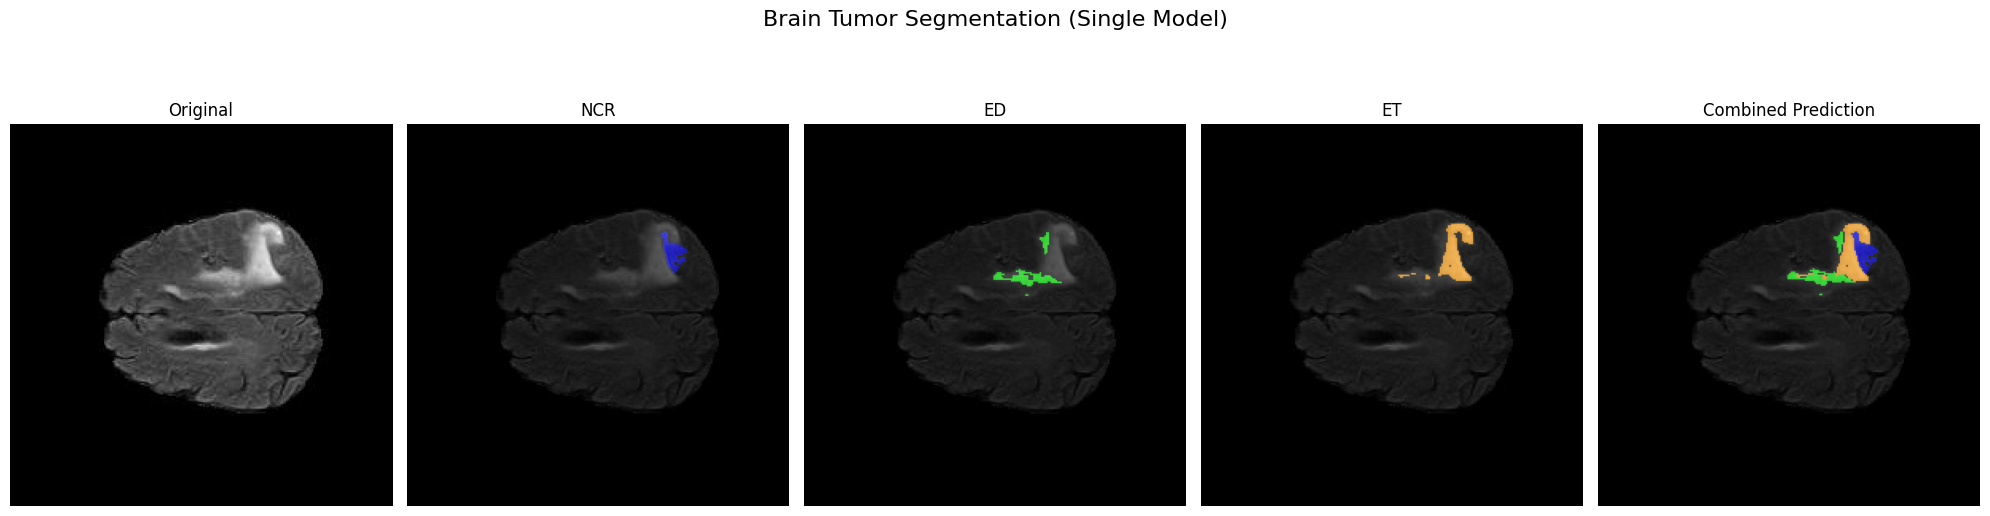

In [14]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torch import nn

# Assuming you have UNetPlusPlus model defined elsewhere
# If not, you would need to add the model definition here

# CBAM (Convolutional Block Attention Module) Implementation

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):  
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8, kernel_size=7):  # Changed from 16 to 8
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

# Enhanced Conv Block with Residual Connections and Dropout

def conv_block(in_channels, out_channels, kernel_size=3, activation=nn.ReLU(inplace=True), dropout_p=0.2):
    """Create a conv block with CBAM attention, residual connection, and dropout"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels),
        activation,
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels),
        activation,
        CBAM(out_channels, reduction_ratio=8),  # Reduced ratio for better attention
        nn.Dropout2d(p=dropout_p)  # Added spatial dropout for regularization
    )

# UNet++ with Enhanced Architecture

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, deep_supervision=True, n_filters=32):
        super(UNetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision
        self.activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        # Encoder (Downsampling Path)
        self.enc1 = conv_block(in_channels, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        self.enc2 = conv_block(1 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.enc3 = conv_block(2 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.enc4 = conv_block(4 * n_filters, 8 * n_filters, activation=self.activation, dropout_p=0.2)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Center / Bottleneck
        self.center = conv_block(8 * n_filters, 16 * n_filters, activation=self.activation, dropout_p=0.3)
        
        # Upsampling
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Nested decoder blocks (UNet++ architecture)
        # Level 1 skip connections (up from level 2)
        self.dec1_1 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 2 skip connections
        self.dec2_1 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.dec1_2 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 3 skip connections
        self.dec3_1 = conv_block(4 * n_filters + 8 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec2_2 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec1_3 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Level 4 skip connections
        self.dec4_1 = conv_block(8 * n_filters + 16 * n_filters, 8 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec3_2 = conv_block(4 * n_filters + 8 * n_filters, 4 * n_filters, activation=self.activation, dropout_p=0.2)
        self.dec2_3 = conv_block(2 * n_filters + 4 * n_filters, 2 * n_filters, activation=self.activation, dropout_p=0.1)
        self.dec1_4 = conv_block(1 * n_filters + 2 * n_filters, 1 * n_filters, activation=self.activation, dropout_p=0.1)
        
        # Output layers for deep supervision
        if self.deep_supervision:
            self.output1 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output2 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output3 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
            self.output4 = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)
        else:
            self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1)

        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        
        # Bottleneck
        bottle = self.center(self.pool(x4))
        
        # Decoder (UNet++ nested architecture)
        # Level 4
        x4_1 = self.dec4_1(torch.cat([x4, self.up(bottle)], dim=1))
        
        # Level 3
        x3_1 = self.dec3_1(torch.cat([x3, self.up(x4)], dim=1))
        x3_2 = self.dec3_2(torch.cat([x3, self.up(x4_1)], dim=1))
        
        # Level 2
        x2_1 = self.dec2_1(torch.cat([x2, self.up(x3)], dim=1))
        x2_2 = self.dec2_2(torch.cat([x2, self.up(x3_1)], dim=1))
        x2_3 = self.dec2_3(torch.cat([x2, self.up(x3_2)], dim=1))
        
        # Level 1
        x1_1 = self.dec1_1(torch.cat([x1, self.up(x2)], dim=1))
        x1_2 = self.dec1_2(torch.cat([x1, self.up(x2_1)], dim=1))
        x1_3 = self.dec1_3(torch.cat([x1, self.up(x2_2)], dim=1))
        x1_4 = self.dec1_4(torch.cat([x1, self.up(x2_3)], dim=1))
        
        # Deep supervision
        if self.deep_supervision:
            output1 = self.output1(x1_1)
            output2 = self.output2(x1_2)
            output3 = self.output3(x1_3)
            output4 = self.output4(x1_4)
            return [output1, output2, output3, output4]
        else:
            output = self.output(x1_4)
            return output

def preprocess_image(image_path, target_size=(240, 240)):
    """
    Preprocess a single MRI image for the brain tumor segmentation model
    """
    # Load image and convert to grayscale if needed
    img = Image.open(image_path)
    if img.mode != 'L':
        img = img.convert('L')
    
    # Resize to target size
    img = img.resize(target_size)
    
    # Convert to numpy array and normalize to [0, 1]
    img_np = np.array(img).astype(np.float32) / 255.0
    
    # Stack the same image 4 times to simulate 4 MRI modalities 
    # (T1, T1ce, T2, FLAIR) - in a real scenario, you'd have separate images
    img_stacked = np.stack([img_np] * 4)
    
    # Convert to torch tensor
    img_tensor = torch.from_numpy(img_stacked).unsqueeze(0)
    
    return img_tensor

def load_pretrained_model(checkpoint_path, device):
    """
    Load a pre-trained UNetPlusPlus model
    """
    model = UNetPlusPlus(in_channels=4, out_channels=3, deep_supervision=True, n_filters=32)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

def run_inference(model, image_tensor, device, test_time_augmentation=True):
    """
    Run inference with optional test-time augmentation
    """
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        if not test_time_augmentation:
            # Standard inference
            if model.deep_supervision:
                output = model(image_tensor)[-1]  # Take the last output if deep supervision
            else:
                output = model(image_tensor)
            return output
        
        # Test-time augmentation (TTA)
        # Original image
        if model.deep_supervision:
            pred_orig = model(image_tensor)[-1]
        else:
            pred_orig = model(image_tensor)
        
        # Horizontal flip
        x_hflip = torch.flip(image_tensor, dims=[3])
        if model.deep_supervision:
            pred_hflip = model(x_hflip)[-1]
        else:
            pred_hflip = model(x_hflip)
        pred_hflip = torch.flip(pred_hflip, dims=[3])
        
        # Vertical flip
        x_vflip = torch.flip(image_tensor, dims=[2])
        if model.deep_supervision:
            pred_vflip = model(x_vflip)[-1]
        else:
            pred_vflip = model(x_vflip)
        pred_vflip = torch.flip(pred_vflip, dims=[2])
        
        # Average predictions
        output = (pred_orig + pred_hflip + pred_vflip) / 3.0
        
        return output

def postprocess_prediction(pred_tensor):
    """
    Convert predictions to binary segmentation mask
    """
    # Apply sigmoid and threshold
    pred_sigmoid = torch.sigmoid(pred_tensor)
    binary_mask = (pred_sigmoid > 0.5).float()
    
    return binary_mask

def visualize_prediction(image, pred_mask):
    """
    Visualize prediction results with individual tumor regions
    - ET: Enhancing Tumor (orange)
    - ED: Edema (green)
    - NCR: Necrotic Core (blue)
    """
    if isinstance(image, torch.Tensor):
        # Use only one channel for display
        image = image[0, 0].cpu().numpy()
    
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()
    
    tumor_classes = ['NCR', 'ED', 'ET']  
    colors = [(0, 0, 1), (0, 1, 0), (1, 0.6, 0)]  # Blue, Green, Orange
    
    fig = plt.figure(figsize=(20, 6))
    
    # Original image
    ax_orig = plt.subplot2grid((1, 5), (0, 0))
    ax_orig.imshow(image, cmap='gray')
    ax_orig.set_title("Original")
    ax_orig.axis('off')
    
    # Individual regions
    for c, (class_name, color) in enumerate(zip(tumor_classes, colors)):
        ax = plt.subplot2grid((1, 5), (0, c+1))
        ax.imshow(image, cmap='gray')
        
        pred_region = pred_mask[0, c]
        overlay = np.zeros((*image.shape, 3), dtype=np.float32)
        for h in range(pred_region.shape[0]):
            for w in range(pred_region.shape[1]):
                if pred_region[h, w] > 0:
                    overlay[h, w] = color
        
        ax.imshow(overlay, alpha=0.6)
        ax.set_title(f"{class_name}")
        ax.axis('off')
    
    # Combined prediction
    ax_pred = plt.subplot2grid((1, 5), (0, 4))
    ax_pred.imshow(image, cmap='gray')
    overlay_pred = np.zeros((*image.shape, 3), dtype=np.float32)
    for c, color in enumerate(colors):
        mask = pred_mask[0, c]
        for h in range(mask.shape[0]):
            for w in range(mask.shape[1]):
                if mask[h, w] > 0:
                    overlay_pred[h, w] = color
    
    ax_pred.imshow(overlay_pred, alpha=0.6)
    ax_pred.set_title("Combined Prediction")
    ax_pred.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.2, top=0.9)
    plt.suptitle("Brain Tumor Segmentation (Single Model)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return fig

def compare_with_ensemble(image, single_pred, ensemble_pred):
    """
    Compare predictions from single model and ensemble
    """
    if isinstance(image, torch.Tensor):
        image = image[0, 0].cpu().numpy()
    
    if isinstance(single_pred, torch.Tensor):
        single_pred = single_pred.cpu().numpy()
    
    if isinstance(ensemble_pred, torch.Tensor):
        ensemble_pred = ensemble_pred.cpu().numpy()
    
    tumor_classes = ['NCR', 'ED', 'ET']
    colors = [(0, 0, 1), (0, 1, 0), (1, 0.6, 0)]  # Blue, Green, Orange
    
    fig = plt.figure(figsize=(15, 8))
    
    # Original image
    ax_orig = plt.subplot2grid((2, 4), (0, 0), rowspan=2)
    ax_orig.imshow(image, cmap='gray')
    ax_orig.set_title("Original MRI", fontsize=14)
    ax_orig.axis('off')
    
    # Single model predictions by region
    for i, (class_name, color) in enumerate(zip(tumor_classes, colors)):
        ax = plt.subplot2grid((2, 4), (0, i+1))
        ax.imshow(image, cmap='gray')
        
        pred_region = single_pred[0, i]
        overlay = np.zeros((*image.shape, 3), dtype=np.float32)
        for h in range(pred_region.shape[0]):
            for w in range(pred_region.shape[1]):
                if pred_region[h, w] > 0:
                    overlay[h, w] = color
        
        ax.imshow(overlay, alpha=0.6)
        ax.set_title(f"Single: {class_name}", fontsize=12)
        ax.axis('off')
    
    # Ensemble model predictions by region
    for i, (class_name, color) in enumerate(zip(tumor_classes, colors)):
        ax = plt.subplot2grid((2, 4), (1, i+1))
        ax.imshow(image, cmap='gray')
        
        pred_region = ensemble_pred[0, i]
        overlay = np.zeros((*image.shape, 3), dtype=np.float32)
        for h in range(pred_region.shape[0]):
            for w in range(pred_region.shape[1]):
                if pred_region[h, w] > 0:
                    overlay[h, w] = color
        
        ax.imshow(overlay, alpha=0.6)
        ax.set_title(f"Ensemble: {class_name}", fontsize=12)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.suptitle("Single Model vs Ensemble Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return fig

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Path to your model checkpoint
    checkpoint_path = '/kaggle/input/unetplusplus/pytorch/default/1/best_brain_segmentation_model.pth'  # Replace with your actual path
    
    # Path to your test image
    image_path = '/kaggle/input/picture/slice1_T1 (2).jpg'  # Replace with your image path
    
    # Load model
    try:
        model = load_pretrained_model(checkpoint_path, device)
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        return
    
    # Preprocess image
    try:
        print(f"Processing image: {image_path}")
        image_tensor = preprocess_image(image_path)
    except Exception as e:
        print(f"Error processing image: {e}")
        return
    
    # Run inference
    try:
        print("Running inference...")
        # Run with test-time augmentation
        prediction = run_inference(model, image_tensor, device, test_time_augmentation=True)
        
        # Process prediction
        processed_pred = postprocess_prediction(prediction)
        print("Inference completed")
    except Exception as e:
        print(f"Error during inference: {e}")
        return
    
    # Visualize results
    try:
        print("Visualizing results...")
        fig = visualize_prediction(image_tensor, processed_pred)
        # Save figure if needed
        # fig.savefig('single_model_segmentation_result.png')
    except Exception as e:
        print(f"Error visualizing results: {e}")
        return

    # If you want to compare with ensemble predictions:
    # This assumes you have an ensemble prediction available
    # You would need to modify this part based on your workflow
    """
    try:
        # Load ensemble predictions or run ensemble model
        ensemble_pred = ...  # Load or generate ensemble predictions
        
        # Compare results
        fig_comparison = compare_with_ensemble(image_tensor, processed_pred, ensemble_pred)
        # Save comparison figure if needed
        # fig_comparison.savefig('segmentation_comparison.png')
    except Exception as e:
        print(f"Error comparing results: {e}")
    """

if __name__ == "__main__":
    main()

In [15]:
import h5py
import numpy as np
from PIL import Image

# 1) Load your .h5
file_path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_190_slice_1.h5"
with h5py.File(file_path, 'r') as f:
    volume = f['image'][:]   # shape (240,240,4)

# 2) Pick a channel (0–3). Here: channel 0 (T1)
slice_2d = volume[:, :, 0]   # shape (240,240)

# 3) Normalize to [0,255]
p = slice_2d.astype(np.float32)
p = (p - p.min()) / (p.max() - p.min() + 1e-8)  # [0,1]
p = (p * 255).astype(np.uint8)                 # [0,255]

# 4) Save as JPEG
im = Image.fromarray(p)
im.save("slice1_T31.jpg")